In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import pandas as pd
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *

## Set up dataloader

In [4]:
DATADRIVE = '/home/jupyter/data/'

In [50]:
interval=0.75
cat_bins = np.arange(0, interval*128, interval)
len(cat_bins), max(cat_bins)

(128, 95.25)

In [51]:
cat_bins[-1] = 1000

In [44]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation_ens10'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn=f'{DATADRIVE}/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-12'),
    val_days=5,
    cat_bins=cat_bins,
    split='train',
    tp_log=1,
    idx_stride=8,
    ensemble_mode='random'
)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [52]:
ds_train.cat_bins = cat_bins

In [53]:
X, y = ds_train[1]
X.shape, y.shape

((1, 16, 16), (128, 128))

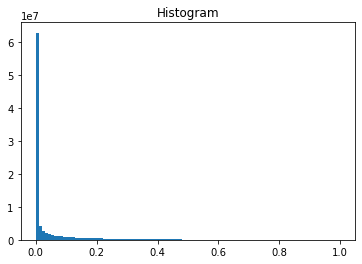

In [54]:
ds_train.tigge.plot(bins=100);

In [55]:
ds_valid = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation_ens10'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn=f'{DATADRIVE}/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-12'),
    val_days=5,
    cat_bins=cat_bins,
    split='valid',
    tp_log=1,
    idx_stride=8,
    ensemble_mode='random'
)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [56]:
sampler_train = torch.utils.data.WeightedRandomSampler(ds_train.compute_weights(
    threshold=interval
), len(ds_train))
sampler_valid = torch.utils.data.WeightedRandomSampler(ds_valid.compute_weights(
    threshold=interval
), len(ds_valid))

In [57]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=16, sampler=sampler_train)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=16, sampler=sampler_valid)

In [58]:
X, y = next(iter(dl_train))
X.shape, y.shape

(torch.Size([16, 1, 16, 16]), torch.Size([16, 128, 128]))

## Set up model

In [59]:
gen = StephanGenerator(
    nres=3, nf_in=ds_train.input_vars, nf=256, nout=128, activation_out=None, use_noise=False,
    spectral_norm=False, halve_filters_up=False, batch_norm=True
).to(device)

In [60]:
count_parameters(gen)

7384704

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-5)

## Train

In [62]:
trainer = Trainer(gen, optimizer, criterion, dl_train, dl_valid)

In [63]:
trainer.fit(6)

Epoch 1:   0%|          | 0/4920 [00:00<?, ?it/s]

/opt/conda/envs/ilan/lib/python3.9/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


KeyboardInterrupt: 

In [26]:
%debug

> /opt/conda/envs/ilan/lib/python3.9/site-packages/torch/nn/functional.py(2824)cross_entropy()
   2822     if size_average is not None or reduce is not None:
   2823         reduction = _Reduction.legacy_get_string(size_average, reduce)
-> 2824     return torch._C._nn.cross_entropy_loss(input, target, weight, _Reduction.get_enum(reduction), ignore_index)
   2825 
   2826 



ipdb>  u


> /opt/conda/envs/ilan/lib/python3.9/site-packages/torch/nn/modules/loss.py(1120)forward()
   1118 
   1119     def forward(self, input: Tensor, target: Tensor) -> Tensor:
-> 1120         return F.cross_entropy(input, target, weight=self.weight,
   1121                                ignore_index=self.ignore_index, reduction=self.reduction)
   1122 



ipdb>  u


> /opt/conda/envs/ilan/lib/python3.9/site-packages/torch/nn/modules/module.py(1051)_call_impl()
   1049         if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks or _global_backward_hooks
   1050                 or _global_forward_hooks or _global_forward_pre_hooks):
-> 1051             return forward_call(*input, **kwargs)
   1052         # Do not call functions when jit is used
   1053         full_backward_hooks, non_full_backward_hooks = [], []



ipdb>  u


> /home/jupyter/repositories/nwp-downscale/notebooks/stephan_notebooks/Experiments_Categorical/src/trainer.py(44)fit()
     42                 X = X.to(device); y = y.to(device)
     43                 y_hat = self.model(X)
---> 44                 loss = self.criterion(y_hat, y)
     45 
     46                 self.optimizer.zero_grad()



ipdb>  y.min()


tensor(-9223372036854775808)


ipdb>  q
